<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/Brain_Motor_Super_Ai_Show_and_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super AI Season 4: Brain Motor Imagery Classification

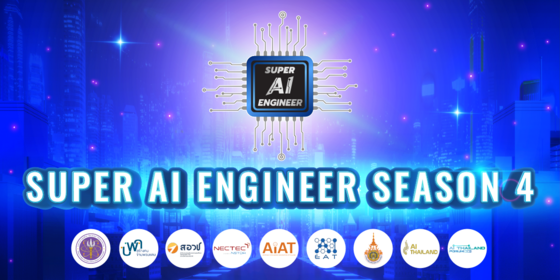

https://www.kaggle.com/competitions/brain-motor-imagery-classification

Second baseline code

Public Score: 0.45235
Private Score: 0.56471

By: Norapat Buppodom (New): https://github.com/new5558


## Init Project

In [ ]:
!pip install -q torch_geometric lightning utilsforecast braindecode

In [ ]:
from google.colab import userdata
kaggle_token = userdata.get('KAGGLE_TOKEN')

import os
import json

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Define the path for the kaggle.json file
kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")

# Write the token to the kaggle.json file
with open(kaggle_json_path, 'w') as file:
    json.dump(json.loads(kaggle_token), file)

# Set the permissions to read and write for the user only
os.chmod(kaggle_json_path, 0o600)

In [ ]:
!kaggle competitions download -c brain-motor-imagery-classification

brain-motor-imagery-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/brain-motor-imagery-classification.zip

Archive:  /content/brain-motor-imagery-classification.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load dataset


In [ ]:
import os

import numpy as np
from tqdm.auto import tqdm
from scipy.signal import butter, filtfilt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from braindecode.models import Deep4Net, EEGNetv4, EEGNetv1, EEGResNet, ShallowFBCSPNet
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics

In [ ]:
%cd /content

/content


In [ ]:
train_path = 'train/train/'

In [ ]:
input_train_list = []
for path in sorted(os.listdir(train_path)):
  if '_data_time_series' in path:
    numpy_loaded = np.load(train_path + path).astype(np.double)
    input_train_list.append(numpy_loaded)

In [ ]:
input_train_list_time_stamp = []
for path in sorted(os.listdir(train_path)):
  if '_data_time_stamps' in path:
    numpy_loaded = np.load(train_path + path)
    input_train_list_time_stamp.append(numpy_loaded)

In [ ]:
input_train_label = []
for path in sorted(os.listdir(train_path)):
  if '_label_time_series.npy' in path:
    numpy_loaded = np.load(train_path + path)
    input_train_label.append(numpy_loaded)

In [ ]:
input_train_label_timestamp = []
for path in sorted(os.listdir(train_path)):
  if '_label_time_stamps.npy' in path:
    numpy_loaded = np.load(train_path + path)
    input_train_label_timestamp.append(numpy_loaded)

In [ ]:
test_path = '/content/test/'

In [ ]:
input_test = []
intpu_test_file_names = []
for path in sorted(os.listdir(test_path)):
  numpy_loaded = np.load(test_path + path).astype(np.double)
  intpu_test_file_names.append(path.split('.')[0])
  input_test.append(numpy_loaded[:1750])

In [ ]:
def find_closest_index(target, arr):
    """Finds the index of the closest value to the target in a NumPy array.

    Args:
        target: The value to find the closest match for.
        arr: The NumPy array to search.

    Returns:
        The index of the closest value in the array.
    """
    distances = np.abs(arr - target)
    closest_index = np.argmin(distances)
    return closest_index

In [ ]:
found_items = []
found_labels = []

for i in tqdm(range(len(input_train_label_timestamp)), total = len(input_train_label_timestamp)):
  for j in range(len(input_train_label_timestamp[i])):
    time_stamp = input_train_label_timestamp[i][j]
    found_index = find_closest_index(time_stamp, input_train_list_time_stamp[i])
    if (len(input_train_list_time_stamp[i]) - found_index) < 1750:
      print('warning index too low', found_index)
      continue
    found_items.append(input_train_list[i][found_index:found_index+1750])
    found_labels.append(input_train_label[i][j])

  0%|          | 0/191 [00:00<?, ?it/s]

warning index too low 52225
warning index too low 53562
warning index too low 44591
warning index too low 54822
warning index too low 54649
warning index too low 54489
warning index too low 54780
warning index too low 54699
warning index too low 54809
warning index too low 55507
warning index too low 54317
warning index too low 54421
warning index too low 54515
warning index too low 54253
warning index too low 54203
warning index too low 54462
warning index too low 54554
warning index too low 54752
warning index too low 54786
warning index too low 54619
warning index too low 54835
warning index too low 54135
warning index too low 54451
warning index too low 54867
warning index too low 54618
warning index too low 54602
warning index too low 54376
warning index too low 54551
warning index too low 54287
warning index too low 54653
warning index too low 54052
warning index too low 54969
warning index too low 54193
warning index too low 54798
warning index too low 54783
warning index too lo

In [ ]:
found_labels_np = np.array(found_labels)

In [ ]:
input_test_np = np.array(input_test)

In [ ]:
input_test_np.shape

(480, 1750, 17)

In [ ]:
found_labels_np.shape

(5718, 1)

In [ ]:
dataset_np = np.array(found_items)

## Preprocess Dataset

In [ ]:
"""เอามาจาก https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter"""
def butter_bandpass(lowcut, highcut, fs, order=5):
   nyq = 0.5 * fs
   low = lowcut / nyq
   high = highcut / nyq
   b, a = butter(order, [low, high], btype='band')
   return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
   y = filtfilt(b, a, data)
   return y

In [ ]:
dataset_np = np.array(dataset_np)
dataset_np_filtered = np.zeros(dataset_np.shape)
for i in tqdm(range(len(dataset_np)), total = len(dataset_np)):
  sample = dataset_np[i]
  for j in range(sample.shape[1]):
    sample_channel = sample[:,j]
    dataset_np_filtered[i,:,j] = butter_bandpass_filter(sample_channel, 3, 40, 250)

  0%|          | 0/5718 [00:00<?, ?it/s]

In [ ]:
input_test_np = np.array(input_test_np)
dataset_np_test_filtered = np.zeros(input_test_np.shape)
for i in tqdm(range(len(input_test_np)), total = len(input_test_np)):
  sample = input_test_np[i]
  for j in range(sample.shape[1]):
    sample_channel = sample[:,j]
    dataset_np_test_filtered[i,:,j] = butter_bandpass_filter(sample_channel, 3, 40, 250)

  0%|          | 0/480 [00:00<?, ?it/s]

In [ ]:
dataset_np_filtered.shape

(5718, 1750, 17)

## Pytorch Step

In [ ]:
import torch.nn as nn
import torch
datset_torch_test_filtered = torch.Tensor(dataset_np_test_filtered).permute((0,2,1))

In [ ]:
datset_torch_filtered = torch.Tensor(dataset_np_filtered).permute((0,2,1))

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# Data Preparation
# Make sure found_labels_np is a PyTorch tensor
found_labels_torch = torch.from_numpy(found_labels_np).long()

# Convert unordered labels to ordered classes
unique_labels = torch.unique(found_labels_torch)
label_map = {label.item(): i for i, label in enumerate(unique_labels)}
ordered_labels = torch.tensor([label_map[label.item()] for label in found_labels_torch])

# Create Dataset and DataLoader
torch_dataset = BrainDataset(datset_torch_filtered, ordered_labels)

"""จริงๆไม่ควร Split แบบนี้ ควร Split แบบ Subject-independent (train กับ validate เป็นคนล่ะคนกัน) มากกว่า"""
train_size = int(0.9 * len(torch_dataset))
test_size = len(torch_dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(torch_dataset, [train_size, test_size], generator = generator1)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        # self.model = EEGBBNet()
        # self.model = Deep4Net(8, 3, n_times=1750, drop_prob=0.5, filter_length_2=5, filter_length_3=5, filter_length_4=5)
        # self.model = Deep4Net(8, 3, n_times=1750)
        # self.model = EEGNetv4(8, 3, n_times=1750)
        """
          ตลกร้ายคือ 17 Channel ให้ผล Private ดีกว่า 8 Channel แต่ Public แย่กว่ามาก
          เดาว่าโมเดลน่าจะเผลอไป Overfit กับค่าอะไรบางอย่าง คะแนนเลยแกว่งมาก"""
        """
          อีกเรื่องที่แปลกคือวิธีนี้ลองแทบทุกโมลเดลใน braindecode แล้วไม่เวิร์ค มีแค่ ShallowFBSCPNet ที่ผลออกมาดี
          ShallowFBSCPNet มีคำว่า FBSCP อยู่ในชื่อ แต่จากการอ่าน Paper + แกะโค้ดไม่พบ FBSCP อยู่ในนั้น เป็นแค่ CNN2D แบบนึงเฉยๆ
        """
        self.model = ShallowFBCSPNet(
            n_chans=17,
            n_times=1750,
            n_outputs=3,
            final_conv_length='auto',
            # drop_prob=0.7,
        )
        self.learning_rate = learning_rate
        self.loss = torch.nn.CrossEntropyLoss()
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3) # metric for validation
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3) # metric for validation

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        data, targets = batch
        output = self.model(data.to(self.device))
        loss = self.loss(output, targets.to(self.device))  # Use CrossEntropyLoss
        self.log("train_loss", loss, prog_bar=True)
        preds = torch.argmax(output, dim=1)
        self.train_acc.update(preds, targets.to(self.device))
        return loss

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        output = self.model(data.to(self.device))
        loss = self.loss(output, targets.to(self.device))  # Use CrossEntropyLoss
        self.log("val_loss", loss, prog_bar=True)
        preds = torch.argmax(output, dim=1)
        self.val_acc.update(preds, targets.to(self.device))

    def on_validation_epoch_end(self):
        self.log('valid_acc_epoch', self.val_acc.compute(), prog_bar=True)
        self.val_acc.reset()

    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

# --- Training Setup ---

# Create the Lightning Module
lit_model = LitModel()

# Callbacks (Early Stopping & Model Checkpointing)
# early_stopping = EarlyStopping(monitor="val_loss", patience=3)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1)

# Trainer
"""จริงๆควร Set Seed ด้วย ผลจะได้เหมือนเดิมทุกครั้ง แต่ตอนที่ทำ Baseline ไม่ได้ทำไว้"""
trainer = pl.Trainer(
    max_epochs=60,
    # callbacks=[early_stopping, checkpoint_callback],
    callbacks=[checkpoint_callback],
    accelerator='auto', # Use GPU if available
    devices='auto',
    deterministic=True
)

/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lit_model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ShallowFBCSPNet    | 41.6 K
1 | loss      | CrossEntropyLoss   | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | train_acc | MulticlassAccuracy | 0     
-------------------------------------------------
41.6 K    Trainable params
0         Non-trainable params
41.6 K    Total params
0.167     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/braindecode/models/modules.py:356: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

## Run Prediction

In [ ]:
lit_model.cuda()
outputs = []
with torch.no_grad():
  for i in range(len(datset_torch_test_filtered)):
    output = lit_model.model(datset_torch_test_filtered[i][None].cuda())
    outputs.append(output)
lit_model.cpu()

In [ ]:
mapper = {
    0: '110',
    1: '120',
    2: '150',
}
outputs_text = []
for output in outputs:
  outputs_text.append(mapper[np.argmax(output.detach().cpu().numpy())])

In [ ]:
df_submission_check = pd.DataFrame({
    "id": intpu_test_file_names,
    "predict": outputs_text
})

In [ ]:
import pandas as pd
submission_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
submission_df

In [ ]:
submission_df_fixed = submission_df.merge(df_submission_check, on ='id')[['id', 'predict_y']].rename(columns={'predict_y': 'predict'})

In [ ]:
submission_df_fixed['predict'].value_counts()

In [ ]:
submission_df_fixed.to_csv('submission_df_fixed.csv', index = False)